In [1]:
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_trf")
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import re
import collections
import itertools
import pickle
from matplotlib.colors import is_color_like as color_check
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

%matplotlib inline

In [2]:
species_dict = pickle.load(open('knowledge_graph.pkl', 'rb'))

In [3]:
species_dict.keys()

dict_keys(['Hypsipetes crassirostris', 'Zygophyllum luntii', 'Ipomoea papilio', 'Bulbostylis somaliensis subsp. confusa', 'Dippers', 'Amorphophallus henryi', 'Pyrenestes ostrinus', 'Eupodotis senegalensis', 'Cuscuta kilimanjari', 'Myzomela caledonica'])

In [4]:
sents = [sent for sent in species_dict['Dippers']]
#cleaned_sents = [nlp(sent) for sent in sents_alt]

In [5]:
species = 'Dippers'

In [67]:
def triplefy(sent):
    
    triples = []
    sent = nlp(sent)
    
    # Init variables
    noun_current = species
    # Get quantities
    quantities = [sent[ent[0].i : ent[-1].i +2] for ent in sent.ents if ent.label_ == 'QUANTITY']
    quantities_idx = [sent[ent[-1].i +1].text for ent in sent.ents if ent.label_ == 'QUANTITY']
    #print(quantities_idx)
    
    #######################
    ### SENTS WITH VERB ###
    #######################
    
    if len([word for word in sent if word.pos_ == 'VERB']) != 0:
        for chunk in sent.noun_chunks:

            #print(chunk)

            ############################
            ### EXTRACT MAIN SUBJECT ###
            ############################ 
            # if nsubj species' part
            if chunk.root.dep_ == 'nsubj':
                triples.append((species, 'has', chunk.root.lemma_))
                # Set new current chunk
                noun_current = chunk.root.lemma_
                # CHeck for amods of NOUNS
                for tok in chunk:
                    if tok == chunk.root:
                        continue
                    if tok.dep_ == 'amod':
                        triples.append((noun_current, 'amod', tok.lemma_))

                ####################################
                ### EXTRACT VERB RELATEN TO MAIN ###
                ####################################
                # Extract the VERB        
                if chunk.root.head.pos_ == 'VERB':
                    verb = chunk.root.head 
                    #print(verb, verb.pos_)
                    # Extract the children
                    for child in verb.children:
                        #print('EXTRACT VERB RELATEN TO MAIN', noun_current, child.lemma_)
                        # Append measurements
                        if child.lemma_ in quantities_idx and child.pos_ == 'ADJ':
                            idx = quantities_idx.index(child.lemma_)
                            triples.append((noun_current, 'be', quantities[idx].text))
                        # Append if ADJ
                        elif child.pos_ == 'ADJ':
                            triples.append((noun_current, verb.lemma_, child.lemma_))   
                        # CHeck if their are addition children
                        for grandchild in child.children:
                            #print('EXTRACT VERB RELATEN TO MAIN', noun_current, grandchild.lemma_)
                            # Measurements
                            if grandchild.lemma_ in quantities_idx and grandchild.pos_ == 'ADJ':
                                idx = quantities_idx.index(grandchild.lemma_)
                                triples.append((noun_current, 'be', quantities[idx].text))
                            # Other ADJs
                            elif grandchild.pos_ == 'ADJ':
                                triples.append((noun_current, verb.lemma_, grandchild.lemma_))
                
                ################################################
                ### MAIN SUBJECT HAS NO VERB (BUT THERE ARE) ###
                ################################################
                elif chunk.root.head.pos_ != 'VERB':
                    print('check')
                    for token in sent:
                        try:
                            if token.pos_ == 'NOUN':
                                #print([parent for parent in token.ancestors])
                                parent = next(parent for parent in token.ancestors if parent.pos_ == 'NOUN')
                                triples.append((parent.lemma_, 'has', token.lemma_))

                            if token.pos_ == 'ADV':
                                parent = next(parent for parent in token.ancestors if parent.pos_ == 'NOUN' or parent.pos_ == 'ADJ')
                                if parent.pos_ == 'NOUN':
                                    if token.pos_ == 'NOUN':
                                        triples.append((parent.lemma_, 'be', token.lemma_))
                                    else:
                                        triples.append((parent.lemma_, 'be', token.text))    
                                else:
                                    triples.append((parent.text, 'advmod', token.text))
                            if token.pos_ == 'ADJ':
                                parent = next(parent for parent in token.ancestors if parent.pos_ == 'NOUN' or parent.pos_ == 'ADJ')
                                if parent.pos_ == 'NOUN':
                                    if token.pos_ == 'NOUN':
                                        triples.append((parent.lemma_, 'be', token.lemma_))
                                    else:
                                        triples.append((parent.lemma_, 'be', token.text))    
                                else:
                                    triples.append((parent.text, 'amod', token.text))
                        except:
                            continue


            ##################################
            ### EXTRACT SUBJECT OF SUBJECT ###
            ################################## 
            elif chunk.root.dep_ == 'pobj':
                triples.append((noun_current, 'has', chunk.root.lemma_))
                #print(chunk)
                # Check for amods
                for idx_c, tok in enumerate(chunk):
                    if tok == chunk.root:
                        # Check for childern
                        for child in tok.children:
                            # Child has verb is had additional features
                            if child.pos_ == 'VERB':
                                for grandchild in child.children:
                                    # Check for measurements
                                    if grandchild.lemma_ in quantities_idx and grandchild.pos_ == 'ADJ':
                                        idx = quantities_idx.index(grandchild.lemma_)
                                        triples.append((tok.lemma_, 'be', quantities[idx].text))
                        #continue
                    if tok.dep_ == 'amod':
                        triples.append((chunk.root.lemma_, 'amod', tok.lemma_))
                        # CHeck for advmods
                        if chunk[idx_c-1].dep_ == 'advmod':
                            triples.append((tok.lemma_, 'advmod', chunk[idx_c-1].lemma_))

            ###################################################
            ### EXTRACT MAIN SUBJECT with ROOT (that, those)###
            ################################################### 
            # If the NOUN == ROOT, use the verb
            elif chunk.root.dep_ == 'ROOT':
                # Append to species
                triples.append((species, 'has', chunk.root.lemma_))
                # Set new current chunk
                noun_current = chunk.root.lemma_
                # Check for amods of NOUNS
                for tok in chunk:
                    if tok == chunk.root:
                        continue
                    if tok.dep_ == 'amod':
                        triples.append((noun_current, 'amod', tok.lemma_))
                # Find the VERB
                for child in chunk.root.children:
                    if child.pos_ == 'VERB' and child.dep_ == 'relcl':
                         # Find the NOUN that goes with it
                        for grandchild in child.children:
                            # If noun append with verb and current NOUN
                            if grandchild.pos_ == 'NOUN' and grandchild.dep_ == 'dobj':
                                triples.append((noun_current, child.lemma_, grandchild.lemma_))
                            # If a new verb has been found extract the nouns
                            elif grandchild.pos_ == 'VERB':
                                # Append the NOUN
                                for great_grandchild in grandchild.children:
                                    if great_grandchild.pos_ == 'NOUN':
                                        triples.append((noun_current, grandchild.lemma_, great_grandchild.lemma_))
                                    # Find the amods
                                    for tok in great_grandchild.children:
                                        if tok.dep_ == 'amod':
                                            triples.append((great_grandchild.lemma_, 'be', tok.text))
                            # Check if exists in measurements
                            elif grandchild.lemma_ in quantities_idx and grandchild.pos_ == 'ADJ':
                                idx = quantities_idx.index(grandchild.lemma_)
                                triples.append((noun_current, 'be', quantities[idx].text))


                    #print(child.pos_, child.dep_, child, object_.lemma_)


            else:
                continue
                #print('xxx', chunk, chunk.root.dep_, chunk.root.pos_)4
            
    ###################################
    ### IF THE SENTENCE IS VERBLESS ###
    ###################################
    # Append all adj, nums and NOUN, might needs update in case of strange behavior
    elif len([word for word in sent if word.pos_ == 'VERB']) == 0:
        #print(noun_current)
        if type(noun_current) != str:
            for child in noun_current.subtree:
                if child.pos_ == 'NUM':
                    triples.append((noun_current.lemma_, 'amount', child.text))
                if child.pos_ == 'ADJ':
                    triples.append((noun_current.lemma_, 'be', child.text))
                if child.pos_ == 'NOUN':
                    triples.append((noun_current.lemma_, 'has', child.text))
        elif type(noun_current) ==  str:
            # Get next NOUN
            noun_current = next(token for token in sent if token.pos_ == 'NOUN')
            triples.append((species, 'has', noun_current.lemma_))
            # Yield list to look back
            #child_list = list(noun_current.subtree)
            for token in sent:
                try:
                    if token.pos_ == 'NOUN':
                        #print([parent for parent in token.ancestors])
                        parent = next(parent for parent in token.ancestors if parent.pos_ == 'NOUN')
                        triples.append((parent.lemma_, 'has', token.lemma_))
                        
                    if token.pos_ == 'ADV':
                        parent = next(parent for parent in token.ancestors if parent.pos_ == 'NOUN' or parent.pos_ == 'ADJ')
                        if parent.pos_ == 'NOUN':
                            if token.pos_ == 'NOUN':
                                triples.append((parent.lemma_, 'be', token.lemma_))
                            else:
                                triples.append((parent.lemma_, 'be', token.text))    
                        else:
                            triples.append((parent.text, 'advmod', token.text))
                    if token.pos_ == 'ADJ':
                        parent = next(parent for parent in token.ancestors if parent.pos_ == 'NOUN' or parent.pos_ == 'ADJ')
                        if parent.pos_ == 'NOUN':
                            if token.pos_ == 'NOUN':
                                triples.append((parent.lemma_, 'be', token.lemma_))
                            else:
                                triples.append((parent.lemma_, 'be', token.text))    
                        else:
                            triples.append((parent.text, 'amod', token.text))
                except:
                    continue


                
        
            
    
    return triples

In [68]:
doc = sents[1]
print(doc)
test = nlp(doc)

Inner webs of primaries partially white, giving a white flash on open wing.


In [69]:
list(test[0].ancestors)

[webs, white]

In [70]:
triplefy(doc) 

check


[('Dippers', 'has', 'web'),
 ('web', 'amod', 'inner'),
 ('web', 'be', 'Inner'),
 ('web', 'has', 'primary'),
 ('white', 'advmod', 'partially'),
 ('flash', 'be', 'white'),
 ('wing', 'be', 'open'),
 ('web', 'has', 'primary'),
 ('web', 'has', 'wing'),
 ('wing', 'amod', 'open')]

In [25]:
displacy.render(nlp(doc), style="dep",)# options={'compact':True})

In [ ]:
displacy.render(nlp(doc), style="ent")

In [54]:
for idx, sent in enumerate(sents):
    print(sent)
    print((triplefy(sent), idx))
    print('\n')

Plumage overall dark gray, paler on chin.
([('Dippers', 'has', 'plumage'), ('gray', 'amod', 'overall'), ('gray', 'amod', 'dark'), ('gray', 'amod', 'paler')], 0)


Inner webs of primaries partially white, giving a white flash on open wing.
Inner webs
primaries
a white flash
open wing
([('Dippers', 'has', 'web'), ('web', 'amod', 'inner'), ('web', 'has', 'primary'), ('web', 'has', 'wing'), ('wing', 'amod', 'open')], 1)


The preen gland is unusually large for a passerine bird and the body-feathers are water-repellant.
The preen gland
a passerine bird
the body-feathers
are VERB
([('Dippers', 'has', 'gland'), ('gland', 'has', 'bird'), ('bird', 'amod', 'passerine'), ('Dippers', 'has', 'feather'), ('feather', 'be', 'repellant')], 2)


Bright colors are absent, plumage is usually gray or brown, sometimes strongly rufous, but blues, greens, and yellows are not found.
Bright colors
plumage
is VERB
blues
greens
yellows
([('Dippers', 'has', 'color'), ('color', 'amod', 'bright'), ('Dippers', 'has',

In [9]:
knowledge_list = [(triplefy(sent),) for sent in tqdm(sents)]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|████████████████████████████████████| 9/9 [00:00<00:00,  9.20it/s]


In [10]:
knowledge_list_flat = [RDF for RDF_list in knowledge_list for RDF in RDF_list]

In [11]:
source = [source[0].lower().strip() for knowledge in knowledge_list_flat for source in knowledge]

relation = [source[1].lower().strip() for knowledge in knowledge_list_flat for source in knowledge]

target = [source[2].lower().strip() for knowledge in knowledge_list_flat for source in knowledge]

In [12]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

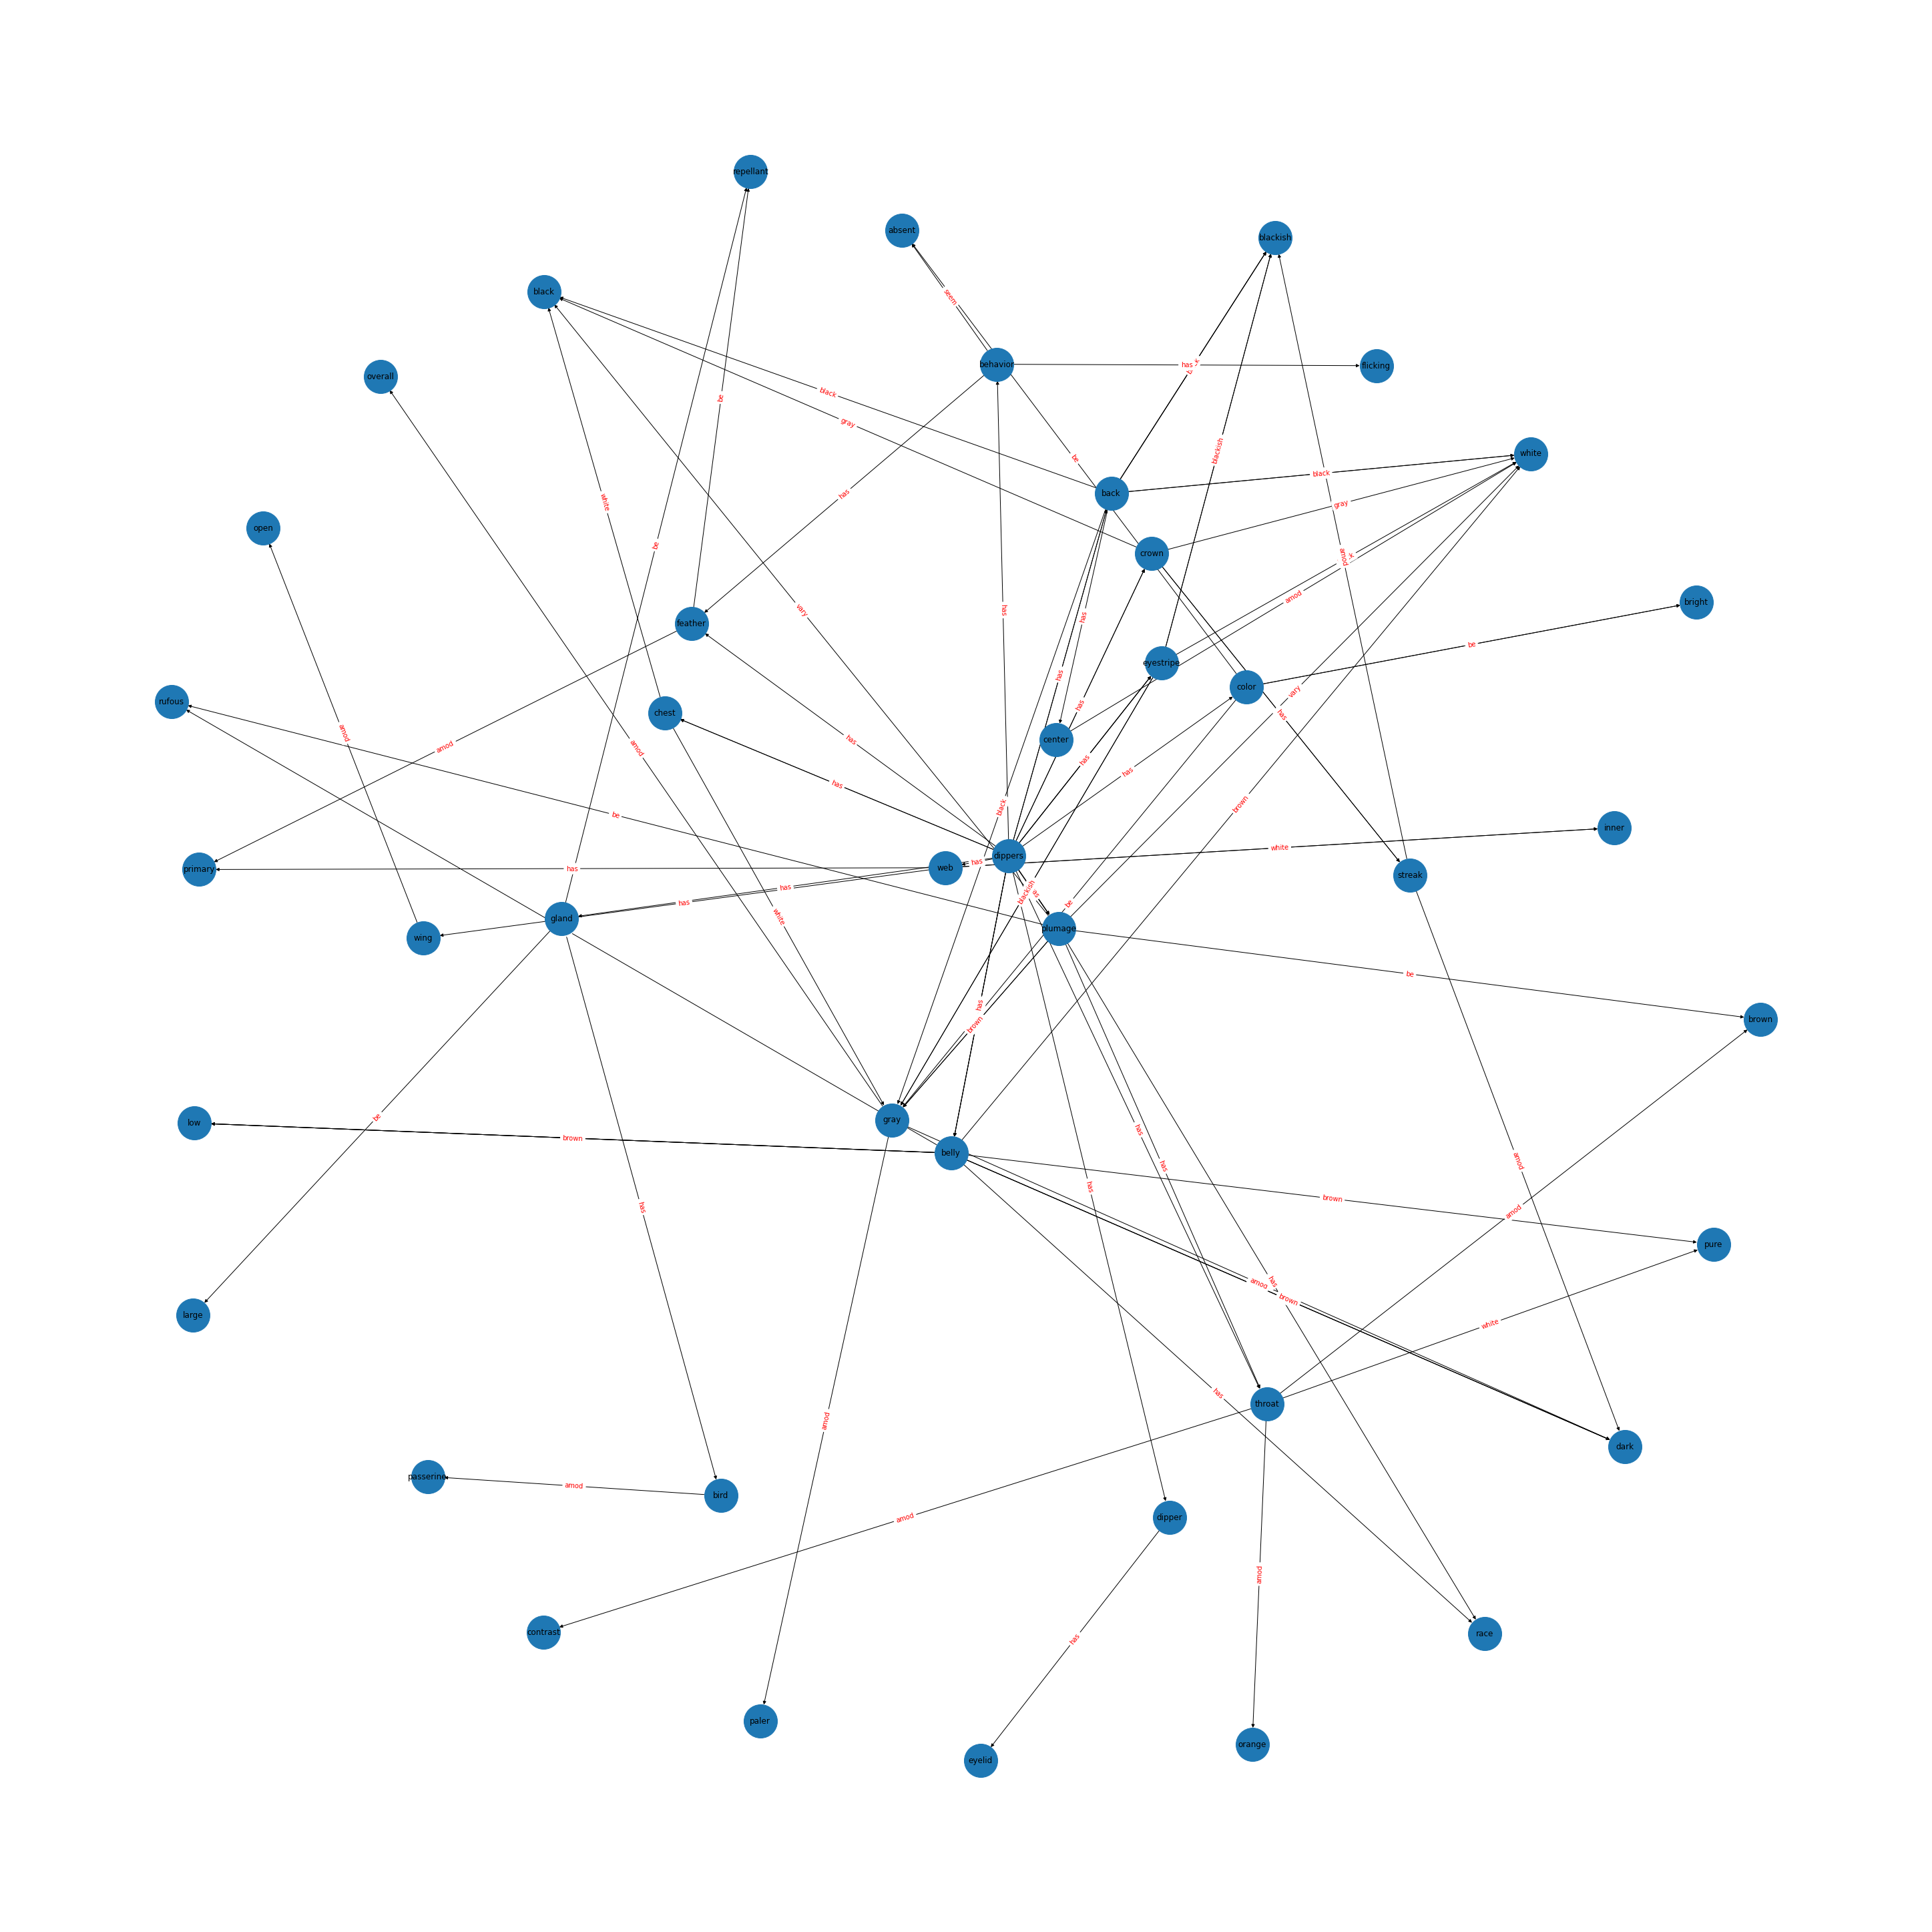

In [13]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(40, 40))
labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_size=2500, pos = pos)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels,
                                 font_color='red')
plt.show()

In [ ]:
kg_df